In [1]:
import os
import math
import time
import numpy as np
import scipy as sp
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib inline
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Functions
## <span style='color:crimson'>Visualization</span>

In [3]:
# visualization
def plot_multi(polymer,L,n, chains,c='dodgerblue'):
    n = n-1
    # Setting x axis ticks on top
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    
    fig = plt.figure(figsize=(size,size))
    ax = fig.add_subplot()
    
    for ii in range(chains):
        ax.scatter(polymer[ii,0,0], polymer[ii,0,1], s = 5000, color='green')
        ax.scatter(polymer[ii,1,0], polymer[ii,1,1], s = 5000, color='cyan')
        ax.scatter(polymer[ii,2:n,0], polymer[ii,2:n, 1], s = 5000, color=c)
        ax.scatter(polymer[ii,n,0], polymer[ii,n,1], s = 5000, color='green')

        #if interrupt == True:
         #   ax.scatter(polymer[ii,lastmon,0], polymer[ii,lastmon,1], s = 5000, color='crimson')

        ax.plot(polymer[ii,:,0],polymer[ii,:,1], color='black')

    # ax.set_xlabel('x')
    ax.set_title('x')  # Note title moves to make room for ticks
    ax.set_ylabel('y')
    
    ax.set_xlim(0,L-1)
    ax.set_ylim(L-1,0)
    ax.grid(True)

    plt.show()

In [4]:
# visualization
def plot_multi(polymer,L,n, chains):
    n = n-1
    # Setting x axis ticks on top
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    
    fig = plt.figure(figsize=(size,size))
    ax = fig.add_subplot()
    
    for ii in range(chains):
        ax.scatter(polymer[ii,:,0], polymer[ii,:, 1], s = 3000)

        #if interrupt == True:
         #   ax.scatter(polymer[ii,lastmon,0], polymer[ii,lastmon,1], s = 5000, color='crimson')

        ax.plot(polymer[ii,:,0],polymer[ii,:,1], color='black')

    # ax.set_xlabel('x')
    ax.set_title('x')  # Note title moves to make room for ticks
    ax.set_ylabel('y')
    
    ax.set_xlim(0,L-1)
    ax.set_ylim(L-1,0)
    ax.grid(True)

    plt.show()

## <span style='color:crimson'>Periodic Boundary Conditions</span>

In [5]:
# wrapping to box
def wrap(r,L):

    if r[0] >= L:
        r[0] -= L
    elif r[0] < 0:
        r[0] += L
    if r[1] >= L:
        r[1] -= L
    elif r[1] < 0:
        r[1] += L

    return r

## <span style='color:crimson'>Distance between two position vectors</span>

In [6]:
# pairwise distance
def dist(r1,r2,L):
    
    halfL = L/2.
    
    dx = r2[0]-r1[0]
    dy = r2[1]-r1[1]
    
    if dx >= halfL:
        dx -= L
    elif dx < -halfL:
        dx += L
        
    if dy >= halfL:
        dy -= L
    elif dy < -halfL:
        dy += L

    return math.sqrt(dx**2+dy**2)

# PARAMETERS 
## <span style='color:crimson'> User-defined Parameters</span>
* Coordinates for the position choices
* Number or possibilities, $k$
* Maximum number of recoil steps, $l_max$
* Size of the squared lattice
* Number of monomers per chain
* Number of chains to be studied

In [7]:
# Coordinates for position choices
positions_xy = [[0,1],[0,-1],[-1,0],[1,0]]

# Number of possibilities
k = 4

# Maximum recoil steps
lmax = 1

# Squared Lattice
size = 20

# Monomers having positions in 2 coordinates (x & y)
N = 15

# Number of chains
chains = 10

# Initializing Grid and Chain Coordinates

## <span style='color:crimson'>Lattice</span>
In the lattice a $0$ indicates there is no particle in that position. A $1$ indicates there is a particle inserted there. A $-1$ indicates we can't try that position any more.

## <span style='color:crimson'>Chain Coordinates</span>
Since $(0,0)$ is a real position in the grid, we initialize the coordinates of all particles with NaN so that they won't be plotted in the grid.

In [8]:
# Initializing grid with 0s
lattice = np.zeros((size,size))


# Initializing positions off lattice because (0,0) is an actual position
polymers = np.full((chains,N,2), np.nan)


# Array to record which of the k position possibilities we have tried
positions_idx = np.zeros((chains, N, k))

# Last monomer of each polymer
lastmon = np.full((chains,1), np.nan)

In [9]:
positions_idx.shape, polymers.shape, lastmon.shape

((10, 15, 4), (10, 15, 2), (10, 1))

# POLYMER CHAINS INSERTION
## <span style='color:crimson'> Insertion of monomer 0 </span>
Monomer 0 is inserted at random in the lattice

## <span style='color:crimson'> Insertion of monomer 1-N </span>

Monomer $i$ should be inserted in any of $k=4$ possible directions from monomer $i-1$:
* **Position 0:** $x$,$y+1$
* **Position 1:** $x$, $y-1$
* **Position 2:** $x-1$, $y$
* **Position 3:** $x+1$, $y$

In [10]:
# Polymer 1

for pp in range(chains):

    retry = True

    while retry == True:
        # Random Coordinate generation
        ran = np.random.randint(size, size=2)

        # Possible X-Coordinate position of monomer 0
        xcoord = int(ran[0])
        # Possible Y-Coordinate position of monomer 0
        ycoord = int(ran[1])

        # Recording position in lattice
        if lattice[ycoord][xcoord] == 0:
            # Polymer 0, Monomer 0
            polymers[pp][0] = ran
            lattice[ycoord][xcoord] = 1
            retry = False

    counter = 0

    # Monomer we are trying to locate
    mon = 1

    while mon < N:
        print('\nMONOMER #', mon)

        # Finding available positions for previous monomer
        available = np.where(positions_idx[pp,mon]==0)
        b = available[0].tolist()
        print('There are %d positions available' %(len(b)))

        # Previous monomer for reference of location
        prev = mon -1

        if len(b) == 0:
            print('NO POSITIONS LEFT TO TRY')
            recoil = True

        while len(b) > 0:
            pos = random.choice(b)
            b.remove(pos)
            print('Attempt Position #%d' %(pos))

            # Possible Coordinates for monomer mon
            xcoord = int(polymers[pp][prev][0])+ positions_xy[pos][0]
            ycoord = int(polymers[pp][prev][1])+ positions_xy[pos][1]

            # Creating temporary vector with possible coordinates for monomer mon
            xy_mon_new = [xcoord, ycoord]

            # Periodic boundary conditions
            xy_mon_wrap = wrap(xy_mon_new,size)
            xcoord = xy_mon_wrap[0]
            ycoord = xy_mon_wrap[1]

            # If there is no monomer in that position
            if lattice[ycoord][xcoord] == 0:
                find = True 
                recoil = False
                print('Successful placement at position#%d: (%d, %d)' %(pos, xcoord, ycoord))

                #Recording accepted attempt in array
                positions_idx[pp][mon][pos] = 1

                # Set Coordinates for monomer mon
                polymers[pp][mon] = [xcoord, ycoord]

                # Record position in lattice
                lattice[ycoord][xcoord] = 1

                # Inform the chain was completely placed
                if mon == N-1:
                    print('We did it!!')
                    interrupt = False
                    lastmon[pp] = mon

                mon += 1


                break

            else:
                print('Position #%d at (%d, %d) is unavailable'%(pos, xcoord,ycoord))

                #Recording unsuccessful attempt in array
                positions_idx[pp][mon][pos] = -1

                if len(b) == 0:
                    recoil = True
                    print(positions_idx[pp])
                    print('DEAD ALLEY!!!!!!')
                    break

        if recoil == True:

            # Finding index of previous monomer and changing it to -1 because it's no longer useful
            used = np.where(positions_idx[pp][prev]==1)
            positions_idx[pp][prev][used[0][0]] = -1
            print('Changing current position of monomer %d to -1' %(prev))
            print(positions_idx[pp])

            # Resetting next monomer indices to 0 because we are changing the chain
            positions_idx[pp][mon][:] = 0
            print('Resetting indices of monomer %d' %mon)
            print(positions_idx[pp])

            # Resetting position of previous monomer in lattice
            print('Resetting position of previous monomer in lattice')
            xcoord = int(polymers[pp][prev][0])
            ycoord = int(polymers[pp][prev][1])
            lattice[ycoord][xcoord] = 0

            print('Resetting position of previous monomer')
            polymers[pp][prev] = np.nan

            # Changing monomer perspective: Starting over from previous monomer
            mon = mon-1

            print('RECOIL to monomer %d...'%(mon))
            print('----------------------------------')

            ####################################################
            ########### Setting recoil-step limit ##############
            ####################################################
            counter += 1

            # Saving the maximum length of the chain for the first recoil
            if counter == 1:
                maxchain = mon

            # If it recoils back to lmax steps from maxchain, it won't continue recoiling
            if mon == (maxchain - lmax):
                interrupt = True
                print('Enough is enough')
                lastmon[pp] = mon-1
                break

            # If the chain grows bigger than the previous maximum length of the chain
            # We reset the counter so that the new monomer can go back down to lmax positions
            if mon > maxchain:
                counter = 0

            # Deactivating recoil step
            recoil = False


MONOMER # 1
There are 4 positions available
Attempt Position #1
Successful placement at position#1: (1, 17)

MONOMER # 2
There are 4 positions available
Attempt Position #2
Successful placement at position#2: (0, 17)

MONOMER # 3
There are 4 positions available
Attempt Position #1
Successful placement at position#1: (0, 16)

MONOMER # 4
There are 4 positions available
Attempt Position #3
Successful placement at position#3: (1, 16)

MONOMER # 5
There are 4 positions available
Attempt Position #1
Successful placement at position#1: (1, 15)

MONOMER # 6
There are 4 positions available
Attempt Position #1
Successful placement at position#1: (1, 14)

MONOMER # 7
There are 4 positions available
Attempt Position #1
Successful placement at position#1: (1, 13)

MONOMER # 8
There are 4 positions available
Attempt Position #0
Position #0 at (1, 14) is unavailable
Attempt Position #2
Successful placement at position#2: (0, 13)

MONOMER # 9
There are 4 positions available
Attempt Position #0
Succe

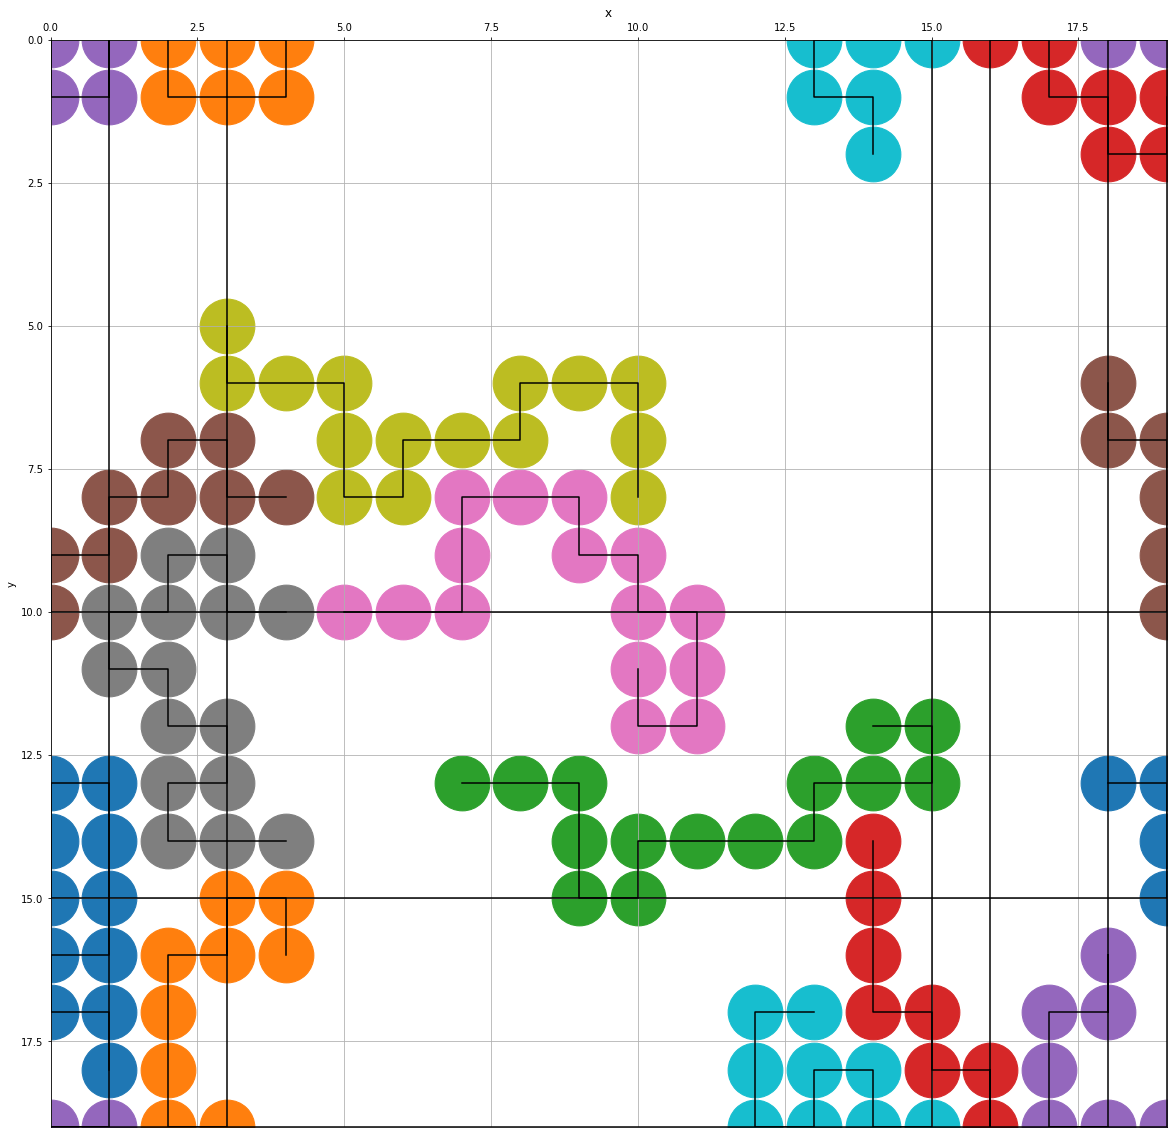

In [11]:
plot_multi(polymers, size, N, chains)

In [13]:
end2end = np.zeros(chains)

print('MEASURABLES: Number of monomers, Chain end-to-end distance\n')

for pp in range(chains):
    end2end[pp] = dist( polymers[pp][0], polymers[pp][int(lastmon[pp])] , size )
    print(f'Polymer #{pp}: {int(lastmon[pp])+1} monomers,{end2end[pp]} units')

end2end

MEASURABLES: Number of monomers, Chain end-to-end distance

Polymer #0: 15 monomers,5.830951894845301 units
Polymer #1: 15 monomers,4.47213595499958 units
Polymer #2: 15 monomers,7.0710678118654755 units
Polymer #3: 15 monomers,8.602325267042627 units
Polymer #4: 15 monomers,4.47213595499958 units
Polymer #5: 15 monomers,6.324555320336759 units
Polymer #6: 15 monomers,5.0990195135927845 units
Polymer #7: 15 monomers,4.0 units
Polymer #8: 15 monomers,7.615773105863909 units
Polymer #9: 15 monomers,5.0990195135927845 units


array([5.83095189, 4.47213595, 7.07106781, 8.60232527, 4.47213595,
       6.32455532, 5.09901951, 4.        , 7.61577311, 5.09901951])